<a href="https://colab.research.google.com/github/sauddy/DPCNet/blob/main/DPCNet_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DPCNet_Build -- 26 November  2020 Colab Compatible

In [1]:
'''
Please note this version of the code is compatible with Google colab 
and will also run on Local machine  

'''
# mount the drive if running from Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
                           ##### IDEA Behind this notebook : ###########
## Author : Sayantan 
## Created : 26 November 2020
## This notebook is adopted from the CNN_DPNNet V3 and V5 (old versions)
## RESNET50, ALEXNET, VGG16 are implemented by Ramit Dey


## We develop a modular notebook that does the following:
## Import all the customized Modules from Modules_DPCNet 
## For data processing we use data_processing.py script 
## A function module to call the different networks independently. (deep_models.py, other_cnn.py)




In [3]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os
import csv

## Modules to check the performance of the code
from time import process_time 
!pip install memory_profiler ## When running from Google Colab
import memory_profiler as mem_profile
print('Memory (Before): {}Mb'.format(mem_profile.memory_usage()))


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score



Memory (Before): [123.78125]Mb


In [4]:
############ Please provide the same path to the code directory if using Colab################

Path_gdrive= '/content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPCNet
import sys
try: ## tries to find the modules in the local directory first
  path ='' # For local computer  
  sys.path.append(path+'MODULES_DPCNeT')
  import data_processing as dp
  import deep_models as dm
  import other_cnns as ocn

  ########### Folders to save the processed data, files and figures when using Local computer ##############
  !mkdir -p data_folder
  !mkdir -p figures ## to save the figurs
  !mkdir -p saved_model
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  #(data folder are a directory above the directory containing the notebook)
  try:
    path = Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPCNeT')
    import data_processing as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figurs
    !mkdir -p figures_paper
    !mkdir -p saved_model
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")



/content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/
We are currently using the Modules_DPCNet
Creating the folders
[INFO] Modules imported


## Load data csv (including the path to images) from multiple time-instances

In [5]:
############# Address to the data folder ###################
list_of_orbits = ['150','140','130','120']

print("[INFO]: Importing files from the datafolder")
## Note the data folder are a directory above the code directory
## Please contact the authors if you need access to the data
folder_address = path + "../analysis_output_"

# The idea is to generate a dataframe with the parameters and the path to the images
data_complete = dp.parse_time_series_data(folder_address,list_of_orbits,path)


[INFO]: Importing files from the datafolder
[INFO] preparing the dataframe from differnt times...
Reading the image paths and data from folder: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/../analysis_output_150/
Reading the image paths and data from folder: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/../analysis_output_140/
Reading the image paths and data from folder: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/../analysis_output_130/
Reading the image paths and data from folder: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/../analysis_output_120/
[INFO] The concatination of dataframes from differnt times are now complete


## Preparing data 

In [6]:
## partition the data csv file into training and testing splits using 85% of
## the data for training and the remaining 15% for testing
split = train_test_split(data_complete, test_size=0.15, random_state=42)
(train, test) = split

## Save the train and the test data for future use as well.
test.to_csv(path+'data_folder/test_dataset.csv')
train.to_csv(path+'data_folder/train_dataset.csv')

## Generate the Normalized data
normed_train_data, normed_test_data, train_labels, test_labels = dp.process_the_disk_attributes(train, test, path)


#### Desired Image resoltuion #####
X_res = Y_res = 256

## Generate the training and the test images 

trainImagesX = dp.load_disk_images(train, X_res, Y_res, Type = "Train")
testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")

Validation_split = 0.15 # 15 percent of the training data is used for validation
print('Memory (After Loading): {}Mb'.format(mem_profile.memory_usage()))
print('There are {} Train, {} Validation and {} Test images'.format(int((1-Validation_split)*len(normed_train_data)),int(Validation_split*len(normed_train_data)),len(normed_test_data)))## check the numbers in each chategory



[INFO] preparing the normalized data training/testing split...
[INFO] Done...
[INFO] Loading images from Train data..
Train Images are loaded
[INFO] Loading images from Test data..
Test Images are loaded
Memory (After Loading): [7901.6328125]Mb
There are 2128 Train, 375 Validation and 442 Test images


## Training the CNN 

In [7]:
## Hyper-Parameter to define
batch_size = 20 ## the best was for 200 last run
valid_batch_size = 20
epochs=200 ## best was 100
init_lr = 1e-5

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=20, verbose=1, mode='min',restore_best_weights=True)



In [8]:
## Select the Network type

# NETWORK = "Vanilla"
# NETWORK = "ALEXNET"
# NETWORK = "VGG"
NETWORK = "RESNET50"

print('INFO: Currently training using the {} NETWORK'.format(NETWORK))
if NETWORK == "Vanilla":
    CNN = dm.build_cnn(X_res, Y_res, 3, regress=True)
elif NETWORK == "ALEXNET":
    CNN = ocn.alexnet(X_res, Y_res, 3, regress=True)
elif NETWORK == "VGG":
    CNN = ocn.cnn_vgg(X_res, Y_res, 3, regress=True)
elif NETWORK == "RESNET50":
    CNN = ocn.ResNet50(X_res, Y_res, 3)
# optimizer = tf.keras.optimizers.Adam(lr_schedule)
optimizer = tf.keras.optimizers.Adam(init_lr, decay=init_lr/2000)
CNN.compile(loss='mean_squared_error',
            optimizer=optimizer,
            metrics=['mean_absolute_error', 'mean_squared_error'])
CNN_history = CNN.fit(x=trainImagesX, y=train_labels,
                  validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])
print('Memory (After Training): {}Mb'.format(mem_profile.memory_usage()))

INFO: Currently training using the RESNET50 NETWORK
Epoch 1/200
107/107 [==============================] - 34s 246ms/step - loss: 3028.8015 - mean_absolute_error: 45.9194 - mean_squared_error: 3028.8015 - val_loss: 5678.2734 - val_mean_absolute_error: 69.3444 - val_mean_squared_error: 5678.2734
Epoch 2/200
107/107 [==============================] - 24s 228ms/step - loss: 774.8699 - mean_absolute_error: 23.5275 - mean_squared_error: 774.8699 - val_loss: 4558.2007 - val_mean_absolute_error: 60.8536 - val_mean_squared_error: 4558.2007
Epoch 3/200
107/107 [==============================] - 24s 224ms/step - loss: 686.6071 - mean_absolute_error: 22.1373 - mean_squared_error: 686.6071 - val_loss: 3678.4238 - val_mean_absolute_error: 53.7598 - val_mean_squared_error: 3678.4238
Epoch 4/200
107/107 [==============================] - 24s 224ms/step - loss: 580.4984 - mean_absolute_error: 20.1113 - mean_squared_error: 580.4984 - val_loss: 2724.5007 - val_mean_absolute_error: 45.2756 - val_mean_squ

/content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/figures


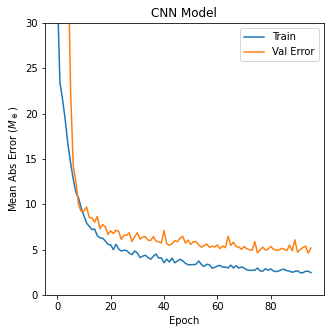

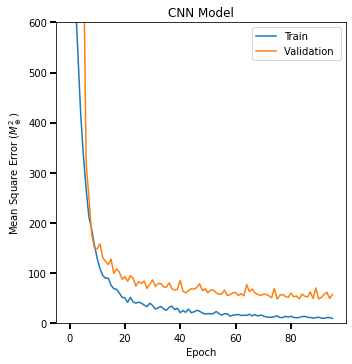

In [9]:
## The plots for the Validation and the Testing loss
dp.plot_history(CNN_history,path, Model = "CNN")
hist_df = pd.DataFrame(CNN_history.history)  ## converting to dataframe
## Saving the history
hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_history.csv')

## Saving the network for future use

In [10]:
# uncomment the following lines if you want to update your model
CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_model')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/saved_model/RESNET50_256_model/assets


In [11]:
## Loading the model
CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_model')
##Check its architecture
# CNN.summary()

## Model Evaluation for DPCNet

In [12]:
loss, mae, mse_CNN = CNN.evaluate(testImagesX, test_labels, verbose=0)
print("Testing set Mean Square Error for {}: {:5.2f} ".format(NETWORK,mse_CNN))
print("Testing set Root Mean Square Error for {}: {:5.2f} M_Earth".format( NETWORK,np.sqrt(mse_CNN)))
print("Testing set Mean Abs Error for {} : {:5.2f} M_Earth ".format(NETWORK,mae))
print("Testing set Loss for {}: {:5.2f} M_Earth".format(NETWORK,loss))

Testing set Mean Square Error for RESNET50: 62.86 
Testing set Root Mean Square Error for RESNET50:  7.93 M_Earth
Testing set Mean Abs Error for RESNET50 :  5.36 M_Earth 
Testing set Loss for RESNET50: 62.86 M_Earth


## Implementing the hybrid model (multi-input), i.e., DPCNet + DPNNet##

In [13]:
DPNNet = dm.DPNNet_build(normed_train_data.shape[1], regress=False)



if NETWORK == "Vanilla":
    CNN_ = dm.build_cnn(X_res, Y_res, 3, regress=False)
elif NETWORK == "ALEXNET":
    CNN_ = ocn.alexnet(X_res, Y_res, 3, regress=False)
elif NETWORK == "VGG":
    CNN_ = ocn.cnn_vgg(X_res, Y_res, 3, regress=False)
elif NETWORK == "RESNET50":
    CNN_ = ocn.ResNet50(X_res, Y_res, 3)

combinedInput = concatenate([DPNNet.output,CNN_.output])
# our final FC layer head will have two dense layers, the final one being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)



## Training the Hybrid Model (DPCNet + DPNNet)

In [14]:
epochs=200 ## best was 100
init_lr = 1e-4
hybrid_model = Model(inputs=[DPNNet.input, CNN_.input], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr_schedule)
optimizer = tf.keras.optimizers.Adam(init_lr,decay=init_lr /200) #, 
hybrid_model.compile(loss='mean_squared_error',
            optimizer=optimizer,
            metrics=['mean_absolute_error', 'mean_squared_error'])
print('INFO: Currently training using the {} NETWORK and DPNNet'.format(NETWORK))
history_hybrid = hybrid_model.fit(x=[normed_train_data, trainImagesX], y=train_labels,
    validation_split = 0.15,verbose=1,
    epochs=epochs, batch_size=batch_size,callbacks=[early_stop])


INFO: Currently training using the RESNET50 NETWORK and DPNNet
Epoch 1/200
107/107 [==============================] - 30s 235ms/step - loss: 6486.1220 - mean_absolute_error: 74.7322 - mean_squared_error: 6486.1037 - val_loss: 6235.7300 - val_mean_absolute_error: 73.2474 - val_mean_squared_error: 6235.7114
Epoch 2/200
107/107 [==============================] - 24s 227ms/step - loss: 6172.8110 - mean_absolute_error: 72.8081 - mean_squared_error: 6172.7933 - val_loss: 6209.5464 - val_mean_absolute_error: 73.0692 - val_mean_squared_error: 6209.5278
Epoch 3/200
107/107 [==============================] - 24s 224ms/step - loss: 6413.9753 - mean_absolute_error: 73.9923 - mean_squared_error: 6413.9562 - val_loss: 6150.3369 - val_mean_absolute_error: 72.6691 - val_mean_squared_error: 6150.3174
Epoch 4/200
107/107 [==============================] - 24s 224ms/step - loss: 6147.0405 - mean_absolute_error: 72.3683 - mean_squared_error: 6147.0214 - val_loss: 5963.3291 - val_mean_absolute_error: 71.38

/content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/figures


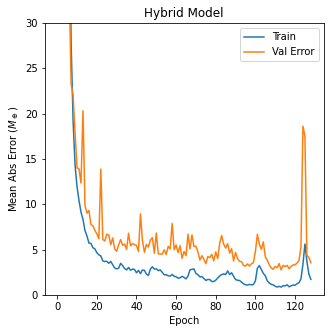

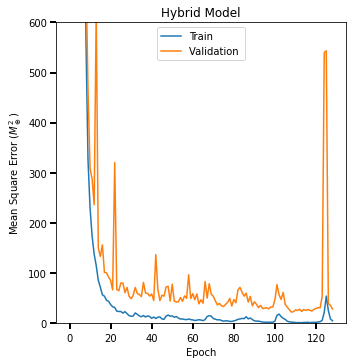

In [15]:
dp.plot_history(history_hybrid,path,Model = "Hybrid")
hist_hybrid = pd.DataFrame(history_hybrid.history) 
hist_hybrid.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_history_hybrid.csv')

In [16]:
hybrid_model.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_hybrid_model') 
hybrid_model = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_hybrid_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/saved_model/RESNET50_256_hybrid_model/assets


## Model Evaluation for Hybrid Model

In [17]:
loss, mae, mse_hybrid = hybrid_model.evaluate([normed_test_data,testImagesX], test_labels, verbose=0)
print("Testing set Mean Square Error for {} with DPNNet: {:5.2f} ".format(NETWORK,mse_hybrid))
print("Testing set Root Mean Square Error for {} with DPNNet: {:5.2f} M_Earth".format( NETWORK,np.sqrt(mse_hybrid)))
print("Testing set Mean Abs Error for {} with DPNNet: {:5.2f} M_Earth ".format(NETWORK,mae))
print("Testing set Loss for {} with DPNNet: {:5.2f} M_Earth".format(NETWORK,loss))

Testing set Mean Square Error for RESNET50 with DPNNet: 27.78 
Testing set Root Mean Square Error for RESNET50 with DPNNet:  5.27 M_Earth
Testing set Mean Abs Error for RESNET50 with DPNNet:  3.24 M_Earth 
Testing set Loss for RESNET50 with DPNNet: 27.82 M_Earth


## Model Predictions and Results

In [18]:
pred_CNN = CNN.predict(testImagesX)
np.shape(pred_CNN)

pred_Hybird = hybrid_model.predict([normed_test_data,testImagesX])
np.shape(pred_Hybird)

(442, 1)

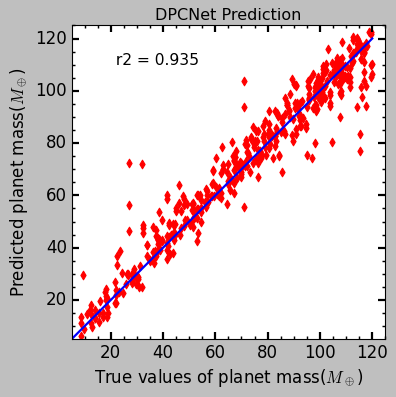

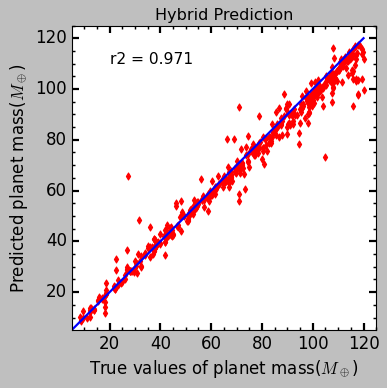

In [19]:
plt.style.use('classic')
plt.figure(figsize = (5,5))
# test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels,pred_CNN.flatten(),s=30,marker='d',color='r')

score_CNN = r2_score(test_labels,pred_CNN.flatten())
plt.text(20,110,r" r2 = {:.3f}".format(score_CNN), fontsize =14)
plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.title("DPCNet Prediction")
plt.axis('equal')
plt.axis('square')
plt.xlim(5,125)
plt.ylim(5,125)

# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 120], [0, 120],linewidth=2)
plt.minorticks_on() 
plt.tight_layout()
plt.savefig('figures/predicted_correlation_CNN.pdf',format='pdf',dpi=300)

plt.tick_params(labelsize=15)

plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.figure(figsize = (5,5))
score_HYBRID = r2_score(test_labels,pred_Hybird.flatten())
plt.text(20,110,r"r2 = {:.3f}".format(score_HYBRID),fontsize =14)
plt.scatter(test_labels,pred_Hybird.flatten(),s=20,marker='d',color='r')
plt.title("Hybrid Prediction")
plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.xlim(5,125)
plt.ylim(5,125)

# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 120], [0, 120],linewidth=2)

plt.minorticks_on() 
plt.tick_params(labelsize=15)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.tight_layout()
plt.savefig('figures/predicted_correlation_hybrid.pdf',format='pdf',dpi=300)
# print("{} r2 score is {}".format(NETWORK,score_CNN))
# print("{} + DPPNET r2 score is {}".format(NETWORK,score_HYBRID))

In [20]:
csv_path = path+'data_folder'
output_filename = os.path.join(csv_path,'res_error'+'.csv')
csv_file = open(output_filename,'a')
csv_writer = csv.writer(csv_file)
# csv_writer.writerow(['Resolution','MSE_CNN','R2_CNN', 'MSE_HYBRID','R2_HYBRID'])
csv_writer.writerow([X_res,mse_CNN,score_CNN,mse_hybrid,score_HYBRID])
csv_file.close()